**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        self.means = X.mean(axis=0)
        self.stds = X.std(axis=0)
        self.labels = np.copy(y)
        if self.algorithm == 'brute':
            self.data = np.copy((X - self.means)/self.stds)
        elif self.algorithm == 'kd_tree':
            self.data = KDTree((X - self.means)/self.stds)
    
    def predict(self, X):
        if self.algorithm == 'brute':
            X = (X - self.means)/self.stds
            #  Get all distances
            distance = np.zeros((X.shape[0], self.data.shape[0]))
            distance = np.apply_along_axis(lambda x: np.sqrt(((self.data - x) ** 2).sum(axis=1)), 1, X)
            #  Find k closest neighbours and classify
            y_out = np.zeros((X.shape[0], 1))
            closest = self.labels[np.fliplr(distance.argsort(axis=1)[:, :self.n_neighbors:])]
            for i in range(0, closest.shape[0]):
                y_out[i, 0] = np.argmax(np.bincount(closest[i, :]))
            return y_out.astype(np.int)
        if self.algorithm == 'kd_tree':
            X = (X - self.means)/self.stds
            closest = self.labels[self.data.query(X, self.n_neighbors)[1]]
            y_out = np.zeros((X.shape[0], 1))
            for i in range(0, closest.shape[0]):
                y_out[i, 0] = np.argmax(np.bincount(closest[i, :]))
            return y_out.astype(np.int)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [10]:
%time clf.predict(X_test)

Wall time: 6.02 ms


array([2, 1, 2, 2, 1, 0, 0, 1, 2, 0, 0, 2, 0, 1, 2])

In [11]:
%time my_clf.predict(X_test)

Wall time: 10.3 ms


array([[2],
       [1],
       [2],
       [2],
       [1],
       [0],
       [0],
       [1],
       [2],
       [0],
       [0],
       [2],
       [0],
       [1],
       [2]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

Wall time: 10.3 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [16]:
%time clf.predict(X_test)

Wall time: 11.4 ms


array([2, 0, 1, 1, 2, 0, 2, 0, 2, 0, 1, 2, 1, 1, 0])

In [17]:
%time my_clf.predict(X_test)

Wall time: 8.62 ms


array([[2],
       [0],
       [1],
       [1],
       [2],
       [0],
       [2],
       [0],
       [2],
       [0],
       [1],
       [2],
       [1],
       [1],
       [0]])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
vectorizer = CountVectorizer(max_features=300)
data_processed = vectorizer.fit_transform(data)
data_processed

<11314x300 sparse matrix of type '<class 'numpy.int64'>'
	with 426257 stored elements in Compressed Sparse Row format>

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [22]:
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
cross_val_score(my_clf, data_processed.toarray(), target, scoring='accuracy', cv=3)

array([0.1519088 , 0.14929727, 0.15221427])

In [23]:
def OptimalKNeighbors():
    out = []
    best_k = 0
    best_score = 0
    for i in range(1, 11):
        my_clf = MyKNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
        score_for_i = cross_val_score(my_clf, data_processed.toarray(), target, scoring='accuracy', cv=3).mean()
        if score_for_i > best_score:
            best_k = i
            best_score = score_for_i
        out.append(score_for_i)
    return out, best_k

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

Optimal value for k is 1


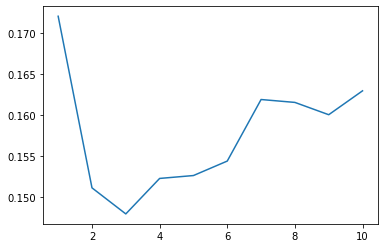

In [24]:
scores, k_optimal = OptimalKNeighbors()
sns.lineplot(x=range(1, 11), y=scores)
print("Optimal value for k is", k_optimal)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [25]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.